In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Load Fashion MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [2]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip to [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [3]:
input_img = tf.keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Latent space: 7x7x16

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [4]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [5]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.4048 - val_loss: 0.3138
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.3097 - val_loss: 0.3086
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.3062 - val_loss: 0.3063
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.3038 - val_loss: 0.3043
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3014 - val_loss: 0.3032
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3006 - val_loss: 0.3020
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.2991 - val_loss: 0.3010
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.2992 - val_loss: 0.3002
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.2980 - val_loss: 0.3002
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.2975 - val_loss: 0.2992
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.2971 - val_loss: 0.2987
Epoch 12/50
469/469 ━━━━━━━━━━

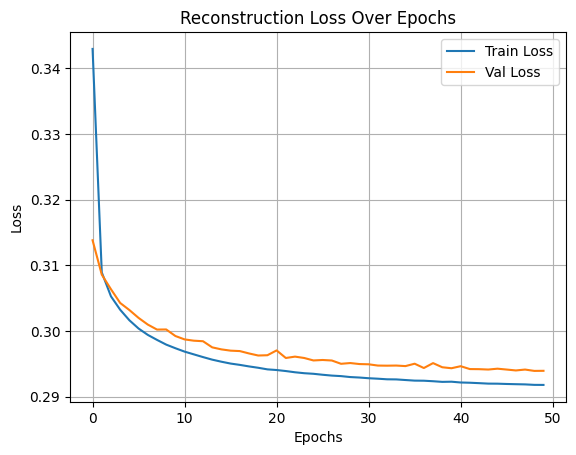

In [6]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


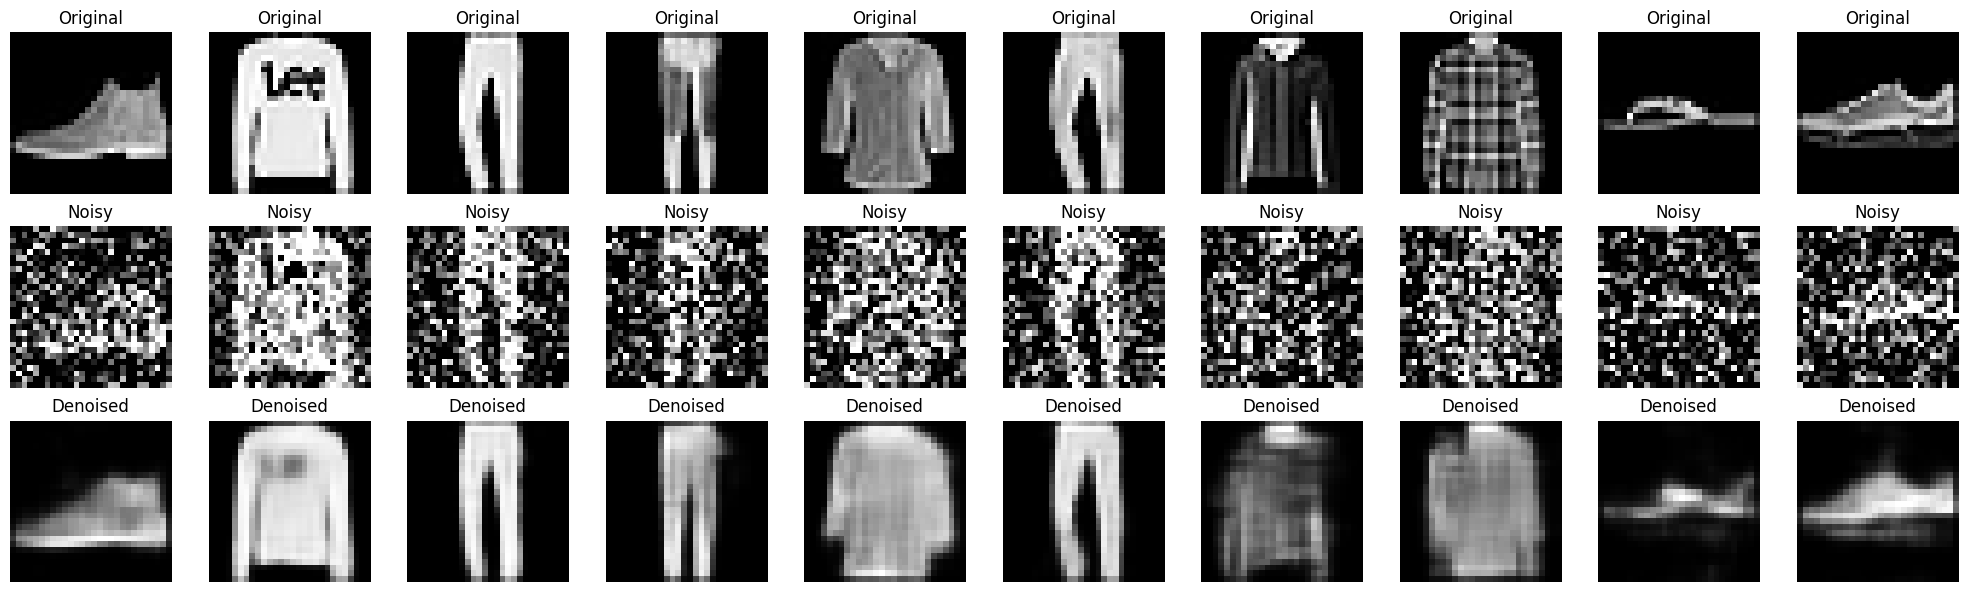

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


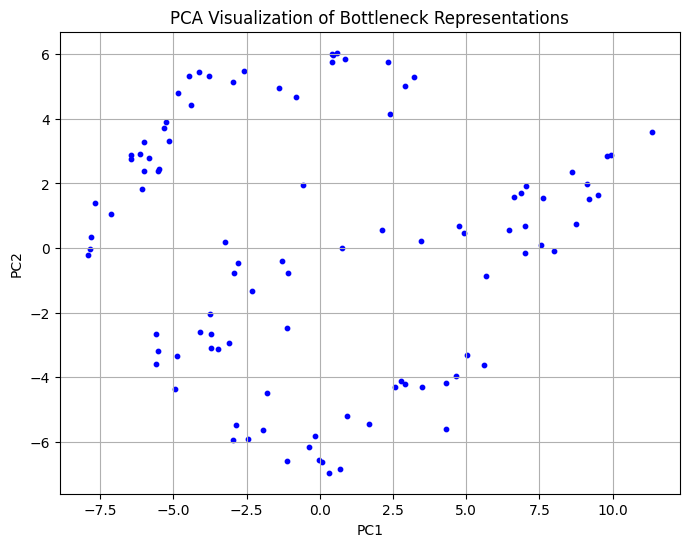

In [ ]:
encoder = models.Model(input_img, encoded)

encoded_imgs = encoder.predict(x_test[:100])

latent_vectors = encoded_imgs.reshape(100, -1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', s=10)
plt.title('PCA Visualization of Bottleneck Representations')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


Summary and Learning:


**Summary**:

This project implements a denoising autoencoder using convolutional layers to reconstruct clean Fashion MNIST images from noisy inputs. The encoder compresses images into a latent bottleneck representation, while the decoder reconstructs the original clean images. The model is trained using binary crossentropy loss, and early stopping is employed to avoid overfitting.

The dataset used is Fashion MNIST, consisting of grayscale 28×28 clothing item images. Gaussian noise is added to simulate corrupted inputs for denoising.

---

**Learnings**:

1. Denoising Autoencoders
- Unlike regular autoencoders, denoising autoencoders learn to remove noise from input images.
- Helps the model learn robust latent features that capture the true structure of data.

2. Convolutional Encoder-Decoder Architecture
- Uses Conv2D + MaxPooling for encoding (downsampling and feature extraction).
- Uses Conv2D + UpSampling for decoding (reconstruction).
- Maintains spatial locality better than Dense layers, leading to **sharper reconstructions**.

3. Bottleneck Visualization
- The latent space (bottleneck) represents compressed features.
- Using PCA, we visualized these compressed vectors to understand how the model encodes images.
- The latent space can help in clustering or anomaly detection.

4. Effect of Adding Noise
- Gaussian noise simulates real-world corrupted data.
- The model learns to generalize better by reconstructing clean images from noisy input.
- Denoised outputs are significantly clearer and smoother than noisy inputs.

5. Early Stopping & Loss Graph
- EarlyStopping halts training when validation loss stops improving, preventing overfitting.
- The reconstruction loss graph shows how the model improves over epochs.